In [1]:
import scanpy as sc
import os,sys
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import matplotlib.ticker as mticker

In [2]:
sc.logging.print_header()

scanpy==1.8.1 anndata==0.7.6 umap==0.5.1 numpy==1.20.1 scipy==1.6.2 pandas==1.3.5 scikit-learn==1.1.3 statsmodels==0.12.2 python-igraph==0.10.6 louvain==0.7.0 pynndescent==0.5.2


In [3]:
# add the utility functions folder to PATH (from Rapolas Zilionis, taken from
# https://github.com/rapolaszilionis/utility_functions)

sys.path.append(os.path.abspath("utility_functions"))

from rz_import_statements import *
import rz_functions as rz
import rz_fig_params # this adjust mpl.rcParams, almost nothing to import, import after scanpy to overwrite rc.Params
import rz_utility_spring as srzc

python version: 3.8.8


In [4]:
#load raw adata
adata = sc.read_h5ad('backups/concatenated_raw_14032128x37733_230831_12h13.h5ad')

## Filtering on total counts and mito fraction

In [5]:
#get total counts
adata.obs['total_counts']= adata.X.sum(axis=1)

In [6]:
# remove barcodes with veeery few counts, e.g. 10 to ease up calculations further

cmask = adata.obs['total_counts'].values>10 
print(adata.shape)
adata = adata[cmask]
print(adata.shape)

(14032128, 37733)
(532324, 37733)


In [7]:
len(adata.obs['library'].unique())

5

In [8]:
adata.var_names = adata.var_names.str.replace('GRCh38_', '')

In [9]:
# define mitochondrial genes 

mitogenes = [i for i in adata.var_names if i.startswith('MT-')]
print (len(mitogenes))
mitogenes
                                                        

13


['MT-ND1',
 'MT-ND2',
 'MT-CO1',
 'MT-CO2',
 'MT-ATP8',
 'MT-ATP6',
 'MT-CO3',
 'MT-ND3',
 'MT-ND4L',
 'MT-ND4',
 'MT-ND5',
 'MT-ND6',
 'MT-CYB']

In [10]:
#calculate mitochondrial percentage and add to obs

mitomask = np.in1d(adata.var_names,mitogenes)

adata.obs['pct_counts_mito'] = np.array(adata.X[:,mitomask].sum(axis=1)).T[0]/adata.obs['total_counts'].values*100.
adata.obs['pct_counts_mito']


73           3.225806
160          8.472597
183          3.225806
258          3.448276
546          1.818182
              ...    
14032123     3.125000
14032124     3.076923
14032125     1.265823
14032126    10.000000
14032127    10.000000
Name: pct_counts_mito, Length: 532324, dtype: float32

In [ ]:
#tidying up the library names, adding minimal information
for i in sorted(adata.obs['library'].unique()):
    print('"%s":"",'%i)

In [12]:
renamer = {
"CD34-04":"10X fresh",
"CD34-01":"InDrop2 fresh 1",
"CD34-02":"InDrop2 fresh 2",
"CD34-05":"10X fixed",
"CD34-03":"InDrop2 fixed",
}

In [ ]:
#In the case of PBMC samples, libraries were renamed as follows:
#"PBMC-05":"Fresh 10X",
#"PBMC-06":"Fixed 10X",
#"PBMC-04":"Fixed InDrop2",
#"PBMC-03":"Fresh InDrop2"

In [ ]:
adata.obs['conditions'] = [renamer[i] for i in adata.obs['library']]
adata.obs.head()

In [14]:
libcol = 'conditions' # column of obs to use

# just a hack to faster fill-in thresholds used, they are set by eye
libs = adata.obs[libcol].unique()

#for entering threshold, copy/paste the output of this cell below
print("ts_dict = {") #for "threshold dictionary"
for lib in libs:
    print('"%s":(3300,20), #(min_nr_counts,max_pct_mito)'%lib)
print('}')

ts_dict = {
"10X fresh":(3300,20), #(min_nr_counts,max_pct_mito)
"InDrop2 fresh 1":(3300,20), #(min_nr_counts,max_pct_mito)
"InDrop2 fresh 2":(3300,20), #(min_nr_counts,max_pct_mito)
"10X fixed":(3300,20), #(min_nr_counts,max_pct_mito)
"InDrop2 fixed":(3300,20), #(min_nr_counts,max_pct_mito)
}


In [25]:
# copy and edit output of previous cell
# first run without any thresholds, then adjust based on the distribution of barcodes

ts_dict = {
"10X fresh":(2000,20), #(min_nr_counts,max_pct_mito)
"InDrop2 fresh 1":(1500,20), #(min_nr_counts,max_pct_mito)
"InDrop2 fresh 2":(2000,20), #(min_nr_counts,max_pct_mito)
"10X fixed":(1500,20), #(min_nr_counts,max_pct_mito)
"InDrop2 fixed":(1800,20), #(min_nr_counts,max_pct_mito)
}

In [ ]:
#In the case of PBMC samples, the thresholds were set as follows:
#"Fresh InDrop2":(3000,20), #(min_nr_counts,max_pct_mito)
#"Fixed InDrop2":(2300,20), #(min_nr_counts,max_pct_mito)
#"Fixed 10X":(2500,20), #(min_nr_counts,max_pct_mito)
#"Fresh 10X":(2500,20), #(min_nr_counts,max_pct_mito)

20021


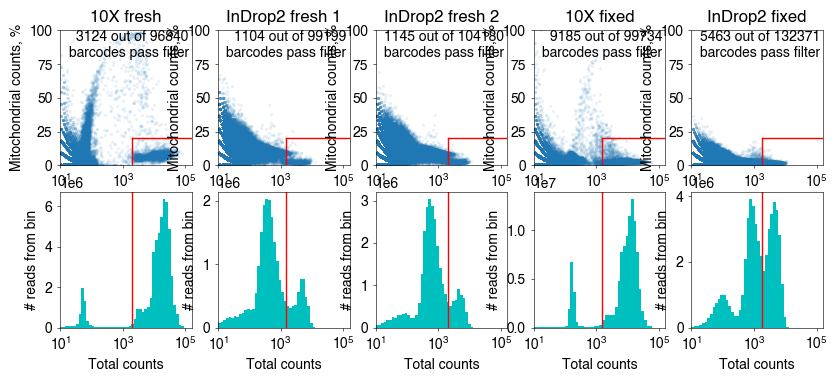

In [26]:
!mkdir -p outputs

plot_title='CD34'
pass_filters = []

#plot mito histograms
nr_rows = math.ceil(len(libs)/5.)

fig,gs = rz.startfig(w=25,h=nr_rows*10,rows=nr_rows*2,columns=5,return_first_ax=False)
#startfig - a custom function by Rapo

# get all the coordinates of the my subplots
coords = np.argwhere(np.zeros([nr_rows,5]) == 0)

# control total count range to expect
xmin = 10
xmax = 10**5.2


for c,lib in zip(coords,libs):
    
    a = fig.add_subplot(gs[c[0]*2,c[1]])
    a1 = fig.add_subplot(gs[c[0]*2+1,c[1]]) #c in coords

    mask = adata.obs[libcol] == lib
    x = adata.obs.loc[mask,'total_counts'] 
    y = adata.obs.loc[mask,'pct_counts_mito']
    
    #scatter
    a.scatter(x,y,lw=0,s=5,alpha=0.1,rasterized=True)
    a.set_xscale('log')
    a.set_xlim(xmin,xmax)
    a.set_ylim(0,100)
    a.set_ylabel('Mitochondrial counts, %')
    a.set_title(lib)
    
    #plot threshold in scatter
    ts = ts_dict[lib]
    a.plot((ts[0],ts[0]),(a.get_ylim()[0],ts[1]),lw=1,color='r')
    a.plot((ts[0],a.get_xlim()[1]),(ts[1],ts[1]),lw=1,color='r')
    pass_ts = (adata.obs.loc[mask,'total_counts']>=ts[0])&(adata.obs.loc[mask,'pct_counts_mito']<ts[1]) 
    cells_pass = pass_ts.sum()
    cells_all = len(pass_ts)
    a.text(a.get_xlim()[1]*0.8,a.get_ylim()[1]*0.8,
           "%d out of %d\nbarcodes pass filter"%(cells_pass,cells_all),
           ha='right')
    
    pass_filters+=(list(pass_ts.values))
    
    # histogram
    bins=np.logspace(np.log10(xmin),np.log10(xmax),51)
    hs, bins,patches = plt.hist(x,bins=bins)
    
    #plot barchart
    lefts = bins[:-1]
    rights = bins[1:]
    a1.bar(x = lefts,width = rights-lefts,height = hs*rights,
          align='edge',
          lw=0.,color = 'c')
    a1.set_xscale('log');
    a1.set_xlim(xmin,xmax)

    # threshold:
    a1.plot((ts[0],ts[0]),(a1.get_ylim()[0],a1.set_ylim()[1]),lw=1,color='r')
    a1.set_xlabel('Total counts')
    
    a1.set_ylabel('# reads from bin')
           

print(sum(pass_filters))
#gs.tight_layout(fig, pad = 0.3)

#plt.savefig('outputs/mito_pct_vs_total_counts_%s.pdf'%(plot_title), dpi=600)
#plt.savefig('outputs/mito_pct_vs_total_counts_%s.png'%(plot_title), dpi=600)

In [27]:
#apply the tresholds to data

cmask = np.repeat(True,adata.shape[0])
print (cmask.sum())
for key,value in ts_dict.items():
    m1 = (adata.obs[libcol] == key).values
    tmp = adata.obs[m1]
    m2 = (tmp['total_counts']>=value[0]).values
    m3 = (tmp['pct_counts_mito']<value[1]).values
    cmask[m1] = m2&m3
    
print(cmask.sum(),cmask.shape)

532324
20021 (532324,)


In [28]:
print( adata.shape)
adata = adata[cmask]
print (adata.shape)

(532324, 37733)
(20021, 37733)


In [29]:
#checking cell count for each sample
for i in adata.obs['conditions'].unique():
    print (i, sum(adata.obs['conditions'] == i))

10X fresh 3124
InDrop2 fresh 1 1104
InDrop2 fresh 2 1145
10X fixed 9185
InDrop2 fixed 5463


In [30]:
for i in sorted(adata.obs['conditions'].unique()):
    print('"%s":"%s",'%(i,i))

"10X fixed":"10X fixed",
"10X fresh":"10X fresh",
"InDrop2 fixed":"InDrop2 fixed",
"InDrop2 fresh 1":"InDrop2 fresh 1",
"InDrop2 fresh 2":"InDrop2 fresh 2",


In [ ]:
#merging 2 InDrops2 libraries together
renamer = {
"10X fixed":"10X fixed",
"10X fresh":"10X fresh",
"InDrop2 fixed":"InDrop2 fixed",
"InDrop2 fresh 1":"InDrop2 fresh",
"InDrop2 fresh 2":"InDrop2 fresh"
}
adata.obs['conditions2'] = [renamer[i] for i in adata.obs['conditions']]
adata.obs.head()

In [ ]:

# write the entire adata object
fname1 = 'backups/filt_raw_%dx%d_%s_%s.h5ad'%(adata.shape[0],adata.shape[1],rz.now(),plot_title)
print(fname1)
adata.write(fname1)



In [ ]:
# save the pandas dataframe under adata.obs 
meta = adata.obs
fname_obs1 = 'backups/obs_info_filt_%dx%d_%s'%(meta.shape[0],meta.shape[1],rz.now())

print(fname_obs1)
rz.save_df(meta,fname_obs1)
